# Tracking the Growth of COVID-19 Cases

The purpose of this notebook is to infer the rate at which confirmed cases of COVID-19 are growing (or were growing) in local Tokyo area.

**The notebook uses [Tokyo COVID-19 Information](https://stopcovid19.metro.tokyo.lg.jp/en)**, and then does the following things:

- List cumulative number of confirmed cases
- Attempt to fit the time series of cumulative confirmed cases to both an exponential and a logistic function
- Use these curve fits to infer doubling times (i.e., time for the number of cumulative confirmed cases to double)

For a great primer on exponential and logistic growth, watch [this video](https://www.youtube.com/watch?v=Kas0tIxDvrg).

## Important Caveats:

- The growth rate (and the doubling time) changes with time. As the exponential curve eventually turns into a logistic curve, the growth rate will shrink to zero (& the doubling time will consequently increase). **So it's not a good idea to extrapolate trends far into the future based on current growth rates or doubling times.**

- The confirmed cases reported by each country are not the number of infections in each country, only those that have tested positive.

- The doubling time calculated here measures the growth of cumulative confirmed cases, which is different from the growth of infections. For example, if a country suddenly ramps up testing, then the number of confirmed cases will rapidly rise, but infections may not be rising as the same rate.

- The doubling times inferred from the curve fits are not necessarily the current or most recent doubling times: 
    - For countries where the growth is still exponential, the inferred doubling time gives us a picture of the overall rate of growth. 
    - For countries where the growth is no longer exponential, and the number of cases is stabilizing (such as China and South Korea), we use a logistic function to fit the data instead. Here, the inferred doubling time represents the growth encountered during the middle of the growth of the epidemic. 
    - Finally, we compare these values to the recent doubling time, calculated from the most recent week of data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil import parser
from pandas.plotting import register_matplotlib_converters
from scipy.optimize import curve_fit

In [2]:
register_matplotlib_converters()

np.seterr(all='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [139]:
df = pd.read_csv('https://stopcovid19.metro.tokyo.lg.jp/data/130001_tokyo_covid19_patients.csv')

In [140]:
def parse_date(dates):
    ret = []
    for d in dates:
        try:
            ret.append(parser.parse(d))
        except:
            pass
    return ret
raw_dates = parse_date(df['公表_年月日'])
dates = np.unique(raw_dates)
count = np.zeros(dates.shape)
for date in raw_dates:
    count[np.where(dates == date)] += 1
sumcount = np.cumsum(count)

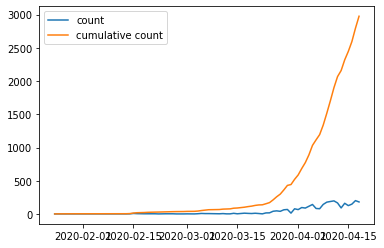

In [141]:
plt.plot(dates, count, label="count")
plt.plot(dates, sumcount, label="cumulative count")
plt.legend()

In [142]:
def logistic(t, a, b, d):
    return (d)/(1 + a * np.exp(- b * t))

def exponential(t, a, b):
    return a * np.exp(b * t)

def plot_growth(dates, count, logistic_extrap=10, exponential_extrap=10):
    raw_x = np.array([(date - dates[0]).days for date in dates])
    x = np.arange(raw_x[0], raw_x[-1])
    y = np.interp(x, raw_x, count) # Linear interpolation of cases doesn't make much sense, but helps fitting

    recentdbltime = float('NaN')
    
    if len(y) >= 7:
        
        current = y[-1]
        lastweek = y[-8]
        
        if current > lastweek:
            print('\n** Based on Most Recent Week of Data **\n')
            print('\tConfirmed cases on',dates[-1],'\t',current)
            print('\tConfirmed cases on',dates[-8],'\t',lastweek)
            ratio = current/lastweek
            print('\tRatio:',round(ratio,2))
            print('\tWeekly increase:',round( 100 * (ratio - 1), 1),'%')
            dailypercentchange = round( 100 * (pow(ratio, 1/7) - 1), 1)
            print('\tDaily increase:', dailypercentchange, '% per day')
            recentdbltime = round( 7 * np.log(2) / np.log(ratio), 1)
            print('\tDoubling Time (represents recent growth):',recentdbltime,'days')

    plt.figure(figsize=(10,5))
    plt.plot(x, y, 'ko', label="Original Data")

    logisticworked = False
    exponentialworked = False

    try:
        lpopt, lpcov = curve_fit(logistic, x, y, maxfev=1000000)
        lerror = np.sqrt(np.diag(lpcov))
        
        # for logistic curve at half maximum, slope = growth rate/2. so doubling time = ln(2) / (growth rate/2)
        ldoubletime = np.log(2)/(lpopt[1]/2)
        # standard error
        ldoubletimeerror = 1.96 * ldoubletime * np.abs(lerror[1]/lpopt[1])
        
        # calculate R^2
        residuals = y - logistic(x, *lpopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        logisticr2 = 1 - (ss_res / ss_tot)  
        
        if logisticr2 > 0.95:
            x_max = x[-1] + logistic_extrap + 1
            log_x = np.hstack([x, np.arange(x[-1] + 1, x_max)])
            plt.plot(log_x, logistic(log_x, *lpopt), 'b--', label="Logistic Curve Fit")
            print('\n** Based on Logistic Fit**\n')
            print('\tR^2:', logisticr2)
            print('\tDoubling Time (during middle of growth): ', round(ldoubletime,2), '(±', round(ldoubletimeerror,2),') days')
            if 0 < logistic_extrap:
                print('\t{} days later, {} cases expected'.format(logistic_extrap, round(logistic(x_max, *lpopt),2)))
            logisticworked = True
    
    except Exception as e:
        print("logistic fit failed: ", e)
        pass

    try:
        epopt, epcov = curve_fit(exponential, x, y, bounds=([0,0],[100,0.9]), maxfev=10000)
        eerror = np.sqrt(np.diag(epcov))
        
        # for exponential curve, slope = growth rate. so doubling time = ln(2) / growth rate
        edoubletime = np.log(2)/epopt[1]
        # standard error
        edoubletimeerror = 1.96 * edoubletime * np.abs(eerror[1]/epopt[1])
        
        # calculate R^2
        residuals = y - exponential(x, *epopt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y - np.mean(y))**2)
        expr2 = 1 - (ss_res / ss_tot)
        
        if expr2 > 0.95:
            x_max = x[-1] + exponential_extrap + 1
            ext_x = np.hstack([x, np.arange(x[-1] + 1, x_max)])
            plt.plot(ext_x, exponential(ext_x, *epopt), 'r--', label="Exponential Curve Fit")
            print('\n** Based on Exponential Fit **\n')
            print('\tR^2:', expr2)
            print('\tDoubling Time (represents overall growth): ', round(edoubletime,2), '(±', round(edoubletimeerror,2),') days')
            if 0 < exponential_extrap:
                print('\t{} days later, {} cases expected'.format(exponential_extrap, round(exponential(x_max, *epopt),2)))
            exponentialworked = True
            
    except Exception as e:
        print("exponential fit failed: ", e)
        pass
    
    plt.title(' Cumulative COVID-19 Cases.', fontsize="x-large")
    plt.xlabel('Days', fontsize="x-large")
    plt.ylabel('Total Cases', fontsize="x-large")
    plt.legend(fontsize="x-large")
    plt.show()



** Based on Most Recent Week of Data **

	Confirmed cases on 2020-04-18 00:00:00 	 2794.0
	Confirmed cases on 2020-04-11 00:00:00 	 1704.0
	Ratio: 1.64
	Weekly increase: 64.0 %
	Daily increase: 7.3 % per day
	Doubling Time (represents recent growth): 9.8 days

** Based on Logistic Fit**

	R^2: 0.998493272106653
	Doubling Time (during middle of growth):  9.23 (± 0.37 ) days

** Based on Exponential Fit **

	R^2: 0.990923504782507
	Doubling Time (represents overall growth):  7.17 (± 0.26 ) days


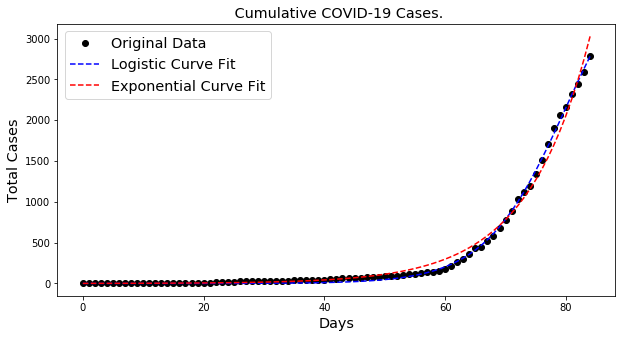

In [143]:
plot_growth(dates, sumcount, 0, 0)